## Proyecto Procesamiento del Lenguaje Natural (NLP): *Detectando spam en URLs*

*Vamos a implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL. Estrategia:*

- *Preprocesado de los datos: eliminación de dominios redundantes, puntuaciones, mayúsculas, símbolos, espacios duplicados, stopwords, palabras de menos de 2 letras, etc.*
- *Tokenización y Lematización*
- *Nube de palabras*
- *Vectorización*
- *Entrenamiento de varios modelos SVM, modificando hiperparámetros (GridSearch) y asignando distintos pesos a las clases (desbalance)*
- *Conclusiones finales*


In [155]:
import pandas as pd
import re
import string 
import nltk
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [58]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...


True

### 1. Preprocesado del texto

In [9]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
pd.set_option('display.max_colwidth', None)
df

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubscribe,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
...,...,...
2994,https://www.smartcitiesworld.net/news/news/deepfake-technology-used-to-advance-autonomous-vehicles-5408,False
2995,https://www.youtube.com/watch,True
2996,https://techcrunch.com/2019/07/04/an-optimistic-view-of-deepfakes/,False
2997,https://www.technologyreview.com/2019/12/20/131462/this-startup-claims-its-deepfakes-will-protect-your-privacy/,False


In [96]:
def preprocess_text(text):

    # Eliminar https://, http://, www.
    text = re.sub(r'https?://|www\.', '', text)

    # Eliminar extensiones de dominio como .com, .es, etc.
    text = re.sub(r'\.\w+', '', text)

    # Sustituir guiones y puntos por espacios en blanco
    text = text.replace('-', ' ').replace('.', ' ')

    text = text.replace('_', ' ')
    
    
    # Eliminar espacios duplicados
    text = re.sub(r'\s+', ' ', text)
 

    # Convertir texto a minúsculas
    text = text.lower()
    text = re.sub(r'[^\w\s]|[\d]', ' ', text) # Eliminar todos los caracteres que no son alfanuméricos (para acabar de limpiar)
    text = re.sub(r'\s+',' ',text).strip() # Eliminar espacios blancos antes de tokenizar

     # Eliminar palabras con dos letras o menos
    text = ' '.join(word for word in text.split() if len(word) > 2)
    # Eliminar palabras que no contienen ninguna vocal
    text = ' '.join(word for word in text.split() if re.search(r'[aeiou]', word))
    
    
    tokens = word_tokenize(text)
    # Quitar las stopwords (palabras poco informativas), from nltk.corpus import stopwords
    stop_w = set([unidecode(w) for w in stopwords.words('english')])

    tokens = [token for token in tokens if token not in stop_w] # filtramos nuestra lista para que sólo queden las palabras que queremos
    
    # Lematización: pasar a infinitivo, a singular, etc. -> Para ello, importaremos from nltk.stem import Word
    lematizador = WordNetLemmatizer()

    tokens = [lematizador.lemmatize(token) for token in tokens if len(token)>=3]
    
    return ' '.join(tokens)


In [104]:
# Ejemplo de aplicación de la función de preprocesado para unaURL aleatorio

url_aleatorio = df.sample(1).url.values[0]
print(f'URL antes de ser preprocesado:\n {url_aleatorio}')
url_aleatorio_prepro = preprocess_text(url_aleatorio)
print('-'*50)
print(f'URL tras ser preprocesado:\n {url_aleatorio_prepro}')

URL antes de ser preprocesado:
 https://www.theskimm.com/picks/things-youll-need-for-a-smooth-road-trip-1NZHuJPUdg31Fybd33NonQ
--------------------------------------------------
URL tras ser preprocesado:
 theskimm pick thing youll need smooth road trip nzhujpudg nonq


In [107]:
# Creamos una columna nueva con los url preprocsados
from tqdm import tqdm
df['url_prepro'] = df['url'].apply(lambda x: preprocess_text(x))

In [109]:
df.head()

,url,is_spam,url_prepro
0,https://briefingday.us8.list-manage.com/unsubscribe,True,briefingday manage unsubscribe
1,https://www.hvper.com/,True,hvper
2,https://briefingday.com/m/v4n3i4f3,True,briefingday
3,https://briefingday.com/n/20200618/m#commentform,False,briefingday commentform
4,https://briefingday.com/fan,True,briefingday fan


In [110]:
# Detectamos y eliminamos duplicados
df.url_prepro.duplicated().sum()

754

In [111]:
df.drop_duplicates(subset='url_prepro', inplace=True)

In [112]:
# Detección de valores faltantes
df['url_prepro'].isna().sum()

0

In [113]:
# Es posible que tras el preprocesado hayan aparecido urls vacías, así que utilizamos este código para filtrar por si fuera necesario
df = df[df['url_prepro']!='']

In [114]:
df.shape

(2244, 3)

In [220]:
df.is_spam.value_counts() # Claro desbalance de clases -> Asignaremos pesos favorables a la clase minoritaria a posterior

is_spam
0    2011
1     233
Name: count, dtype: int64

/tmp/ipykernel_7892/246054440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['word_count'] = df.url_prepro.apply(lambda x:len(x.split()))


array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

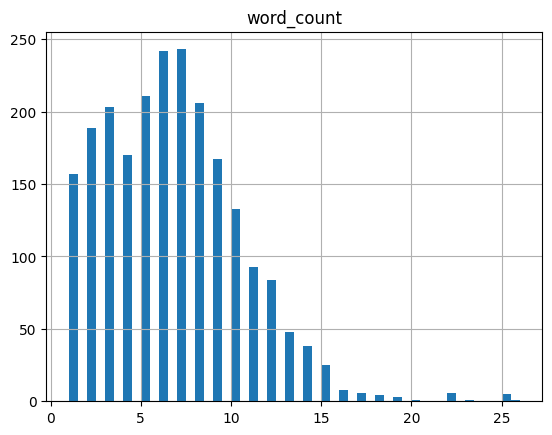

In [118]:
# Creamos una columna para conteo de palabras y graficamos
df['word_count'] = df.url_prepro.apply(lambda x:len(x.split()))
df.hist('word_count', bins = 50)

In [145]:
# Comenzamos con el proceso de nube de palabras
is_spam = df.is_spam.unique()
is_spam

array([1, 0])

In [146]:
df['is_spam'] = df['is_spam'].replace({True: 1, False: 0}) # Transformamos el target en numérico

/tmp/ipykernel_7892/2414521213.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_spam'] = df['is_spam'].replace({True: 1, False: 0})


In [147]:
is_spam

array([1, 0])

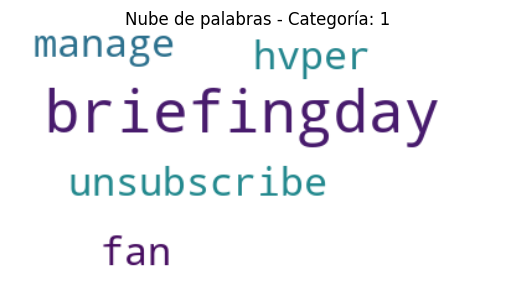

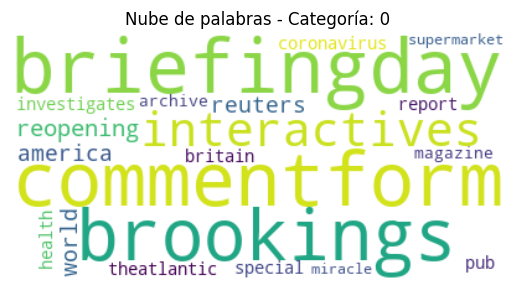

In [154]:
for result in is_spam:
  url = ' '.join(df[df.is_spam == result]['url_prepro'][:4].tolist())
  wordcloud = WordCloud(background_color="white", max_words=20, contour_color="steelblue", collocations=True)
  wordcloud.generate(url)
  # Mostrar la nube de palabras para cada partido
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f"Nube de palabras - Categoría: {result}")
  plt.axis("off")
  plt.show()

### 2. Vectorización

In [156]:
X_train, X_test, y_train, y_test = train_test_split(df.url_prepro, df.is_spam, test_size=0.2, random_state=63)

In [157]:
# Creamos la versión vectorizada de los textos desechando palabras que aparezcan en menos del 0.1% de los documentos
vectorizer = TfidfVectorizer(min_df=0.001)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)

In [158]:
len(vectorizer.get_feature_names_out()) # Comprobamos qué longitud de palabras se nos ha quedado en train

1568

In [159]:
X_train_num.toarray().shape

(1795, 1568)

### 3. Modelizado por SVM

In [182]:
# Modelo 1
model = SVC(kernel="rbf", C=1.0, gamma=0.5) # modificamos algunos hiperparámetros

# Entrenar el modelo
model.fit(X_train_num.toarray(), y_train)

# Realizar predicciones
y_pred = model.predict(X_test_num.toarray())

In [183]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       404
           1       0.88      0.47      0.61        45

    accuracy                           0.94       449
   macro avg       0.91      0.73      0.79       449
weighted avg       0.94      0.94      0.93       449



In [185]:
# Modelo 2
total_weight = len(y_train)

# Calcular los pesos para cada clase
weight_0 = 0.3 * total_weight
weight_1 = 0.7 * total_weight
class_weights = {0: weight_0, 1: weight_1}

# Crear el modelo SVM con pesos para las clases
model = SVC(kernel="rbf", C=1.0, gamma=0.5, class_weight=class_weights)

# Entrenar el modelo
model.fit(X_train_num.toarray(), y_train)

# Realizar predicciones
y_pred = model.predict(X_test_num.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       404
           1       0.67      0.58      0.62        45

    accuracy                           0.93       449
   macro avg       0.81      0.77      0.79       449
weighted avg       0.92      0.93      0.93       449



In [ ]:
# Búsqueda de mejores hiperparámetros
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly']
}


svm_model = SVC(class_weight=class_weights)


grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_num.toarray(), y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Mejores hiperparámetros encontrados:
{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

In [217]:
# Modelo 3

total_weight = len(y_train)

# Calcular los pesos para cada clase
weight_0 = 0.2 * total_weight
weight_1 = 0.8 * total_weight
class_weights = {0: weight_0, 1: weight_1}

# Crear el modelo SVM con pesos para las clases
model = SVC(kernel="rbf", C= 0.5, gamma=0.001, class_weight=class_weights)

# Entrenar el modelo
model.fit(X_train_num.toarray(), y_train)

# Realizar predicciones
y_pred = model.predict(X_test_num.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       404
           1       0.67      0.64      0.66        45

    accuracy                           0.93       449
   macro avg       0.82      0.80      0.81       449
weighted avg       0.93      0.93      0.93       449



In [219]:
# Modelo 4

total_weight = len(y_train)

# Calcular los pesos para cada clase
weight_0 = 0.1 * total_weight
weight_1 = 0.9 * total_weight
class_weights = {0: weight_0, 1: weight_1}

# Crear el modelo SVM con pesos para las clases
model = SVC(kernel="rbf", C= 0.5, gamma=0.001, class_weight=class_weights)

# Entrenar el modelo
model.fit(X_train_num.toarray(), y_train)

# Realizar predicciones
y_pred = model.predict(X_test_num.toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       404
           1       0.60      0.71      0.65        45

    accuracy                           0.92       449
   macro avg       0.79      0.83      0.81       449
weighted avg       0.93      0.92      0.93       449



*Conclusiones finales:*

- *Hemos estado modificando hiperparámetros y pesos asignados (por el desbalance de clases) para intentar encontrar una mejora significa de todas las métricas. No obstante, normalmente el F1 score aumenta a costa de la pérdida de precisión.*

- *Si damos más importancia a la precisión general del modelo, el modelo 1 y el 4 tienen la precisión más alta.*

- *Si por lo contrario, nos centramos especialmente en la capacidad de detectar URLs spam (Clase 1), el modelo 3 tiene el F1-score más alto para esa clase.

- *Por último, si buscamos un equilibrio, el modelo 2 parece ofrecer un buen compromiso, con un F1-score aceptable para la clase 1 y una precisión general alta.*

- *En mi opinión, creo que lo importante en estos casos es  evitar que un email importante (no spam) termine en la carpeta de spam (falso positivo), entonces el aspecto más relevante a considerar es el recall para la clase de no spam (Clase 0). Todos los modelos tienen valores altos para esta métrica, por lo que cualquiera de los modelos sería bastante válido y útil.*









In [222]:
# Guardado del modelo
from joblib import dump
dump(model, 'modelo_entrenado_NLP.joblib')

['modelo_entrenado_NLP.joblib']